In [7]:
from lamp import Pinv_ilamp
from NNinv import NNinv_torch
from rbf_inv import RBFinv

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_swiss_roll
# mnist 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

### Generate some data

In [8]:
# X, y = make_swiss_roll(n_samples=2000, noise=0.2, random_state=0, hole=False)

# ## scale the data to [0,1] is required for the NNinv
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# ## plot the original data
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap=plt.cm.jet)

## MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype('float32')/255.0
y = y.astype('int64')


X, _, y, _ = train_test_split(X, y, train_size=20000, random_state=420) ## you may need to use all the data 

## select only 0 and 7 || or try 1 and 7
mask = (y == 0) | (y == 7)
X = np.array(X[mask])
y = np.array(y[mask])
print(X.shape, y.shape)


C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(4002, 784) (4002,)


### Build  $P$ and $P^{-1}$

C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


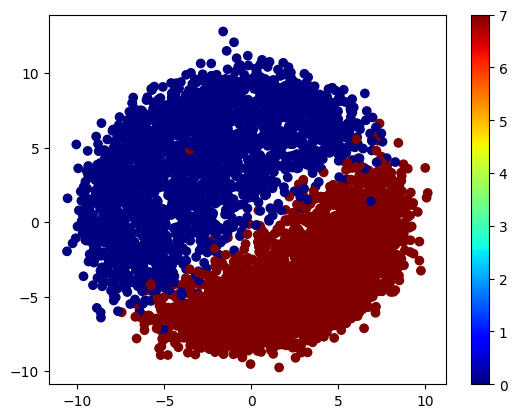

In [9]:
## P, using MDS
X2d = MDS(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)

plt.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
# cbar
plt.colorbar()

In [10]:
## Pinv with ilamp
ilamp = Pinv_ilamp(k=6)
ilamp.fit(X2d, X)

## Pinv with NNinv
nninv = NNinv_torch(dims=[2048, 2048, 2048, 2048],) ## this structure is according the original paper, but it seems too large for most of the datasets we teset (like any 3D dataset, or the MNIST). But it works
nninv.fit(X2d, X, epochs=100)

## Pinv with RBF
rbf = RBFinv()
rbf.fit(X2d, X)

device:  cuda:0
Epoch 1/100, Loss: 0.08339202
Epoch 2/100, Loss: 0.05468326
Epoch 3/100, Loss: 0.04741306
Epoch 4/100, Loss: 0.04236693
Epoch 5/100, Loss: 0.04096589
Epoch 6/100, Loss: 0.04050106
Epoch 7/100, Loss: 0.04013824
Epoch 8/100, Loss: 0.03991972
Epoch 9/100, Loss: 0.03972334
Epoch 10/100, Loss: 0.03956362
Epoch 11/100, Loss: 0.03946511
Epoch 12/100, Loss: 0.03931713
Epoch 13/100, Loss: 0.03918312
Epoch 14/100, Loss: 0.03912502
Epoch 15/100, Loss: 0.03908158
Epoch 16/100, Loss: 0.03904217
Epoch 17/100, Loss: 0.03909670
Epoch 18/100, Loss: 0.03931552
Epoch 19/100, Loss: 0.03922142
Epoch 20/100, Loss: 0.03891885
Epoch 21/100, Loss: 0.03875626
Epoch 22/100, Loss: 0.03871621
Epoch 23/100, Loss: 0.03868711
Epoch 24/100, Loss: 0.03866475
Epoch 25/100, Loss: 0.03863191
Epoch 26/100, Loss: 0.03858186
Epoch 27/100, Loss: 0.03857848
Epoch 28/100, Loss: 0.03856549
Epoch 29/100, Loss: 0.03856111
Epoch 30/100, Loss: 0.03853617
Epoch 31/100, Loss: 0.03854442
Epoch 32/100, Loss: 0.03852599
E

### Inverse proejction some 2D points

In [11]:
## sample some points in the 2D space

xmin, xmax = X2d[:,0].min(), X2d[:,0].max()
ymin, ymax = X2d[:,1].min(), X2d[:,1].max()

x_ = np.linspace(xmin, xmax, 10)
y_ = np.linspace(ymin, ymax, 10)

xx, yy = np.meshgrid(x_, y_)
samples = np.c_[xx.ravel(), yy.ravel()]

## Pinv with ilamp
samples_ilamp = ilamp.transform(samples)

## Pinv with NNinv
samples_nninv = nninv.transform(samples)

## Pinv with RBF
samples_rbf = rbf.transform(samples)


100%|██████████| 100/100 [00:00<?, ?it/s]


Text(0.5, 0.98, 'RBF')

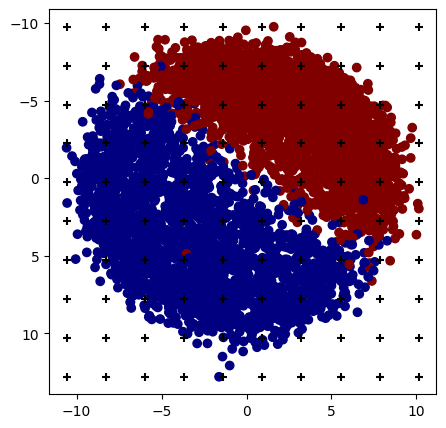

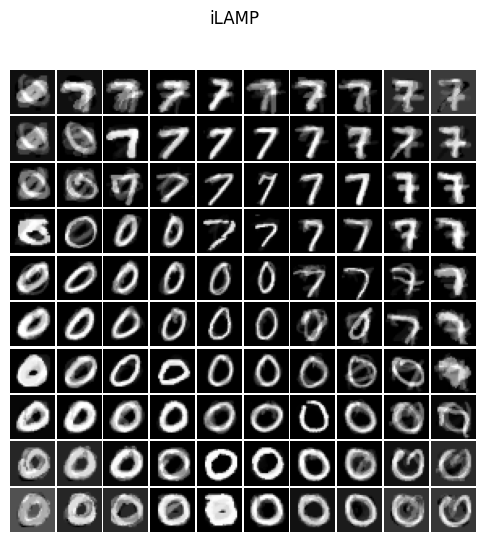

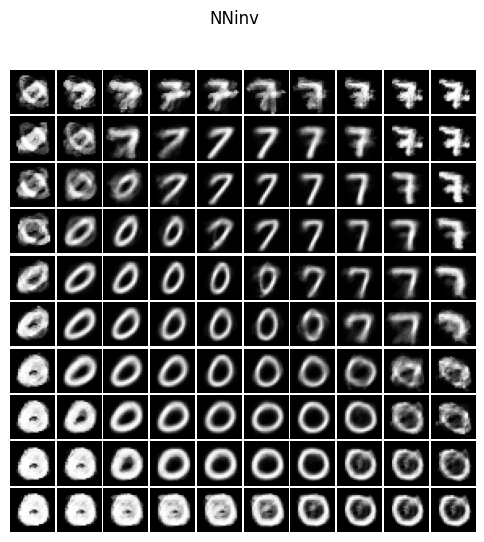

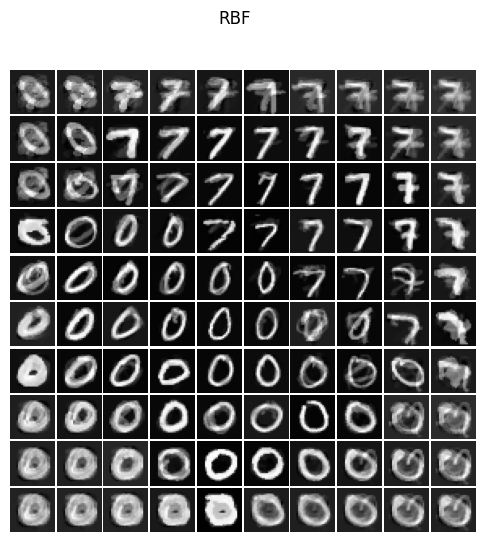

In [12]:
## plot the results
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
ax.scatter(samples[:,0], samples[:,1], c='black', marker='+')
ax.invert_yaxis()

## results of ilamp
fig1, axes = plt.subplots(10, 10, figsize=(6,6))
fig1.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_ilamp[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig1.suptitle('iLAMP')

## results of NNinv
fig2, axes = plt.subplots(10, 10, figsize=(6,6))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_nninv[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig2.suptitle('NNinv', )

## results of RBF
fig3, axes = plt.subplots(10, 10, figsize=(6,6))
fig3.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_rbf[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig3.suptitle('RBF')